In [1]:
# load our dependencies
import os
from glob import glob
from pathlib import Path
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]=""

import numpy as np
from omegaconf import OmegaConf
import tensorflow.compat.v1 as tf
from neuralDecoder.neuralSequenceDecoder import NeuralSequenceDecoder

#### Demo: saliency map analysis

This notebook provides an overview of the phonetic similarity analysis from Fig. 3, using the baseline RNN and eval data provided on Dryad.

In [2]:
# First set your base directory. This should contain a subfolder derived/ containing associated Dryad files
baseDir = '/oak/stanford/groups/shenoy/ghwilson/T12Saliency/'

In [3]:
# Initialize RNN model and datasets
ckptDir = baseDir + '/derived/rnns/baselineRelease'

args = OmegaConf.load(os.path.join(ckptDir, 'args.yaml'))
args['loadDir'] = ckptDir
args['mode'] = 'infer'
args['loadCheckpointIdx'] = None

for x in range(len(args['dataset']['datasetProbabilityVal'])):
    args['dataset']['datasetProbabilityVal'][x] = 0.0

for sessIdx in range(4,19):
    args['dataset']['datasetProbabilityVal'][sessIdx] = 1.0
    args['dataset']['dataDir'][sessIdx] = baseDir+'/derived/tfRecords'
args['testDir'] = 'test'

# Initialize model
tf.compat.v1.reset_default_graph()
nsd = NeuralSequenceDecoder(args)

2023-06-21 07:07:22.820754: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-21 07:07:22.820811: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: sh03-17n03.int
2023-06-21 07:07:22.820821: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: sh03-17n03.int
2023-06-21 07:07:22.820933: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 530.30.2
2023-06-21 07:07:22.820980: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 530.30.2
2023-06-21 07:07:22.820986: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 530.30.2
2023-06-21 07:07:22.821367: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU inst

Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 multiple                  28317696  
                                                                 
 gru_2 (GRU)                 multiple                  6297600   
                                                                 
 gru_3 (GRU)                 multiple                  6297600   
                                                                 
 gru_4 (GRU)                 multiple                  6297600   
                                                                 
 gru_5 (GRU)                 multiple                  6297600   
                                                                 
 dense (Dense)               multiple                  42025     
                                                                 
Total params: 53,551,145
Trainable params: 53,551,145
Non-train

                                                                 
 dropout_4 (Dropout)         (None, None, 256)         0         
                                                                 
Total params: 65,792
Trainable params: 65,792
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, None, 256)         65792     
                                                                 
 dropout_5 (Dropout)         (None, None, 256)         0         
                                                                 
Total params: 65,792
Trainable params: 65,792
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_6"
_________________________________________________________________
 Layer (type)           

                                                                 
 dropout_16 (Dropout)        (None, None, 256)         0         
                                                                 
Total params: 65,792
Trainable params: 65,792
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, None, 256)         65792     
                                                                 
 dropout_17 (Dropout)        (None, None, 256)         0         
                                                                 
Total params: 65,792
Trainable params: 65,792
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_18"
_________________________________________________________________
 Layer (type)         

Now we'll define the GradientGetter class - which we use for computing saliency - and a helper function.

In [6]:
class GradientGetter():
    '''Simple object for handling saliency map computation. Accepts inputs:
    
        rnnModel (NeuralSequenceDecoder object) - model to analyze
        rnnInputs (2D float) - time x channels of neural data to use
        n_perturbations (int) - # of noise perturbations, see below
        noise_level (float)   - noise strength in [0, 1], see below
        
        The paper uses SmoothGrad (https://arxiv.org/pdf/1706.03825.pdf), a method for 
        cleaning up saliency maps by averaging gradients over noisy perturbations of the input 
        data. Using n_perturbations = 1 and noise_level = 0 yields the standard saliency map
        strategy. In the speech decoding paper, we used SmoothGrad to obtain a small boost 
        in performance but for demo purposes we've turned it off by default.
        '''
    
    def __init__(self, rnnModel, rnnInputs, n_perturbations = 1, noise_level = 0):
        self.rnnModel  = rnnModel
        self.rnnInputs = rnnInputs
        
        assert n_perturbations >= 1, "N_perturbations must be >= 1"
        assert noise_level >= 0, "noise_level must be >= 0"
        # Set n_perturbations = 1, noise_level = 0 for vanilla saliency maps 
        # Set n_perturbations = 20, noise_level = 0.1 for our results
        
        self.n_perturbations = n_perturbations # SmoothGrad perturbations per timepoint 
        self.noise_level     = noise_level     # noise SD as fraction of data range (0.1-0.2 in SmoothGrad paper)
        self.print_fraction  = 0.1  # print progress 

    def __call__(self):
        '''Heavy lifting done here. Step through the input neural data and calculate jacobians 
           of outputs with respect to input channels. 
           
           Returns:
               
               gradients (list of 4D float) - entries are extra dim x outputs x input kernel x 256 channels
        '''
        
        timelen = self.rnnInputs.shape[0]
        delta   = self.rnnModel.model.stack_kwargs['kernel_size']
        stride  = self.rnnModel.model.stack_kwargs['strides']

        noise_sd = self.noise_level * (np.percentile(self.rnnInputs, 98) - np.percentile(self.rnnInputs, 2))

        t = 0
        gradients = list()
        while t <= timelen - delta:
            step_data  = self.rnnInputs[t:(t + delta), :]

            noise_grads = list()
            for i in range(self.n_perturbations):
                noisy_data = step_data + tf.random.normal(step_data.shape, 0, noise_sd)
                noise_grads.append(self.computeTimestepSaliency(noisy_data))

            step_grads = tf.math.reduce_mean(tf.concat(noise_grads, axis = 0), axis = 0, keepdims = True)
            gradients.append(step_grads)
            t += delta + stride
            
            #if (timeline - delta) * self.print_fraction
            print(t, '/', timelen - delta)
        return gradients

    
    @tf.function
    def computeTimestepSaliency(self, rnnInput):
        '''Runs a single datapoint (32 consecutive timepoints) through model. Inputs are:
    
        rnnInput (2D tensor) - timepoints x channels'''
    
        rnnStates = [self.rnnModel.model.initStates, None, None, None, None, None]

        with tf.GradientTape(persistent = True) as g:
            #x = data
            x = tf.tile(rnnInput[tf.newaxis, :,:], [1, 1, 1])
            x = tf.cast(x, tf.float32)
            g.watch(x)

            for t in range(5):
                output = self.rnnModel.normLayers[layerIdx](x)
                output = self.rnnModel.inputLayers[layerIdx](output)
                output, rnnStates = self.rnnModel.model(output, rnnStates, training=False, returnState=True)

            logitOut = tf.squeeze(output, 0)
            y        = tf.cast(logitOut, tf.float32)

        jacobian = g.batch_jacobian(y, x, experimental_use_pfor = False)
        return jacobian
    
    
def getSimilarity(vectors, subtractMean = False, metric = 'similarity'):
    '''Inputs are:
    
        vectors (2D float)  - classes x feature matrix
        subtractMean (Bool) - toggle across-class mean subtraction
        metric (str)        - either 'similarity' (cosine sim) or a metric for 
                              sklearn's pdist function 
                              
        Returns <dists> which is a classes x classes distance/similarity matrix
    '''
    
    if subtractMean:
        vectors -= np.mean(vectors, axis = 0, keepdims = True)

    if metric == 'similarity':
        normed = vectors / np.linalg.norm(vectors, axis = 1)[:, None]
        dists  = normed @ normed.T
    else:
        dists = squareform(pdist(vecs, metric))

    return dists


Let's load some example data from a single session and compute gradients of the output phone probabilities with respect to the input channels:

In [59]:
datasetIdx = -2

dataset   = list(nsd.tfValDatasets[datasetIdx])[0]
layerIdx  = nsd.args['dataset']['datasetToLayerMap'][datasetIdx]
gradients = list()
for idx in range(dataset['inputFeatures'].shape[0]):
    data      = dataset['inputFeatures'][idx, :dataset['nTimeSteps'][idx], :]
    getter    = GradientGetter(nsd, data)
    gradients.extend(getter())
    
    print(idx+1, '/', dataset['inputFeatures'].shape[0])
    # break # uncomment this line for a much faster demo

36 / 207
72 / 207
108 / 207
144 / 207
180 / 207
216 / 207
1 / 40
36 / 314
72 / 314
108 / 314
144 / 314
180 / 314
216 / 314
252 / 314
288 / 314
324 / 314
2 / 40
36 / 181
72 / 181
108 / 181
144 / 181
180 / 181
216 / 181
3 / 40
36 / 234
72 / 234
108 / 234
144 / 234
180 / 234
216 / 234
252 / 234
4 / 40
36 / 345
72 / 345
108 / 345
144 / 345
180 / 345
216 / 345
252 / 345
288 / 345
324 / 345
360 / 345
5 / 40
36 / 254
72 / 254
108 / 254
144 / 254
180 / 254
216 / 254
252 / 254
288 / 254
6 / 40
36 / 184
72 / 184
108 / 184
144 / 184
180 / 184
216 / 184
7 / 40
36 / 170
72 / 170
108 / 170
144 / 170
180 / 170
8 / 40
36 / 286
72 / 286
108 / 286
144 / 286
180 / 286
216 / 286
252 / 286
288 / 286
9 / 40
36 / 123
72 / 123
108 / 123
144 / 123
10 / 40
36 / 229
72 / 229
108 / 229
144 / 229
180 / 229
216 / 229
252 / 229
11 / 40
36 / 150
72 / 150
108 / 150
144 / 150
180 / 150
12 / 40
36 / 223
72 / 223
108 / 223
144 / 223
180 / 223
216 / 223
252 / 223
13 / 40
36 / 288
72 / 288
108 / 288
144 / 288
180 / 288
216

We've now computed our Jacobians! These matrices track the gradient of each (logit) output with respect to the input neural features (hence why we use "gradient" interchangeably - the Jacobian is just a matrix tracking all of these 256 inputs x 40 outputs gradients). 

After averaging across timepoints, each output logit (representing a phoneme probability) will now have an associated set of weights on the input channels. These reflect how to budge each channel's activity to maximize the probability of a given class.

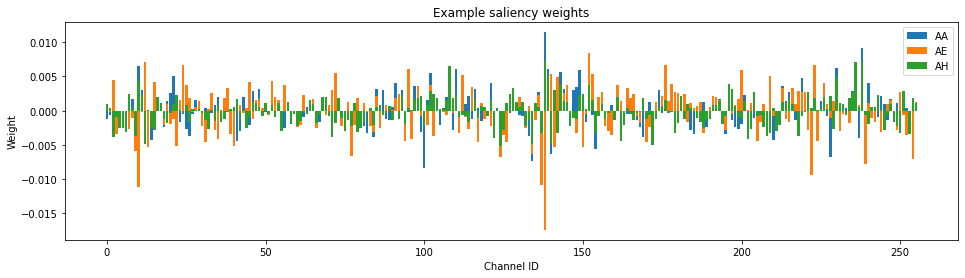

In [60]:
# Import phone index ordering so we know which entry corresponds to which phone
from neuralDecoder.datasets.speechDataset import PHONE_DEF

# collapse gradients across timepoints and remove CTC blank component (index 40):
jacobians = np.dstack(gradients).squeeze().mean(axis=1)[:40, :]

# some plotting stuff
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Rectangle

plt.figure(figsize=(16, 4))

_ = plt.bar(np.arange(256), jacobians[0, :], label = PHONE_DEF[0])
_ = plt.bar(np.arange(256), jacobians[1, :], label = PHONE_DEF[1])
_ = plt.bar(np.arange(256), jacobians[2, :], label = PHONE_DEF[2])
plt.xlabel('Channel ID')
plt.ylabel('Weight')
plt.title('Example saliency weights')
plt.legend()

Next we'll average across time and compute a similarity score between sets of gradients.

In [61]:
# First define consonant and vowel groupings: 

CONSONANTS_GRPS = [['P', 'B', 'M', 'F', 'V'], # labial
                   ['TH', 'DH'],              # dental
                   ['T', 'D', 'N', 'S', 'Z'], # alveolar
                   ['CH', 'JH', 'SH', 'ZH'],  # post-alveolar
                   ['NG', 'K', 'G'],          # velar/palatal
                   ['Y', 'L', 'R', 'W'],      # approximant
                   ['HH']]                    # glottal fricative

VOWELS_GRPS = [['OY', 'OW', 'AO', 'AA', 'AW', 'AY', 'AE', 'EH', 'EY', 'IY', 'IH', 'AH', 'UW', 'ER', 'UH']]


CONSONANTS = np.concatenate(CONSONANTS_GRPS)
VOWELS     = np.concatenate(VOWELS_GRPS)

VOWELS_IDX     = [PHONE_DEF.index(ph) for ph in VOWELS]
CONSONANTS_IDX = [PHONE_DEF.index(ph) for ph in CONSONANTS]

In [62]:
metric       = 'similarity' # distance metric between gradients
centerGroups = True         # toggle mean subtraction within consonants and vowels separately


# optional - center within groups to highlight within-group structure
if centerGroups:
    for grp_idx in [CONSONANTS_IDX, VOWELS_IDX]:
        jacobians[grp_idx, :] -= np.mean(jacobians[grp_idx, :], axis = 0, keepdims=True)

# compute similarity between pairs of phoneme gradients:
dists = getSimilarity(jacobians, subtractMean=False, metric = metric)

Finally let's plot the resulting distance/similarity matrices:

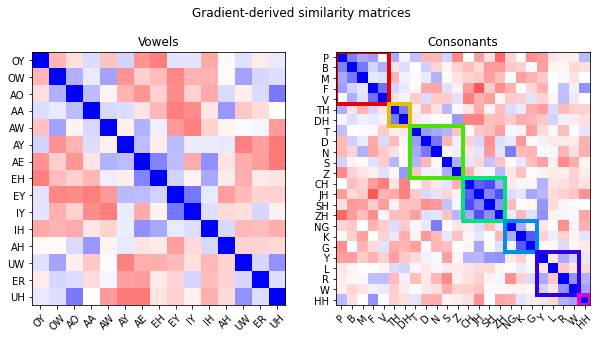

In [63]:
plt.figure(figsize = (10, 5))
plt.suptitle('Gradient-derived similarity matrices')

for i, (ph_type, PHONES_GRPS, subset) in enumerate(zip(['Vowels', 'Consonants'], [VOWELS_GRPS, CONSONANTS_GRPS], [VOWELS_IDX, CONSONANTS_IDX])):
    PHONES_SUBSET  = np.asarray(subset)
    PHONES         = list(np.concatenate(PHONES_GRPS))
    dist_subset    = dists[subset, :][:, subset]
    
    plt.subplot(1, 2, i+1)
    plt.imshow(dist_subset, clim = [-1, 1], cmap = 'bwr_r')
    plt.xticks(ticks=np.arange(len(PHONES_SUBSET)), labels=PHONES, rotation=45)
    plt.yticks(ticks=np.arange(len(PHONES_SUBSET)), labels=PHONES)
    plt.title(ph_type)
    
    if len(PHONES_GRPS) > 1:
        groups      = [[PHONES.index(ph) for ph in grp] for grp in PHONES_GRPS]
        groupColors = cm.hsv(np.linspace(0,1,len(groups)+1)[0:len(groups)])*0.9

        currentAxis = plt.gca()
        for gIdx in range(len(groups)):
            thisIdx = groups[gIdx]
            currentAxis.add_patch(Rectangle((thisIdx[0] - 0.5, thisIdx[0] - 0.5), len(thisIdx), len(thisIdx),
                                  alpha=1, facecolor='none', edgecolor=groupColors[gIdx,:], linewidth=4))


Looking alright! In the paper, we actually compute similarity matrices for each session (with SmoothGrad as well, mentioned in `GradientGetter` notes) and then average the resulting matrices together. 

Nevertheless we can see some articulatory structure in these maps without all the fancy bells and whistles. For instance, the labial fricatives (F, V) are more similar to each other than the bilabials (P, B, and M) and vice-versa. And together these labials cluster more closely than compared to other phonemes.